<a href="https://colab.research.google.com/github/NickKornienko/Language-Identification-model/blob/main/LanguageUnderstanding_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# we went through all the audio files and saved their MFCCs (40 MFCC per audio sample) and lables in a pickle file, which we will be using for analysis and training purpose
df = pd.read_pickle('/content/drive/MyDrive/all_data.pkl')
df.head()

0           1          2          3          4          5  \
0 -368.843903   77.270210 -28.758459  28.591148  -9.293530  -6.967359   
1 -292.091400  107.465469 -44.139664  44.164894 -17.887180 -12.471088   
2 -318.740234   95.526634 -39.401192  27.715158 -22.705025  -6.303998   
3 -315.532990   92.288322 -40.423939  34.508945 -18.966898  -4.724030   
4 -301.566803   83.467590 -43.062504  54.350731 -23.995485   0.010661   

          6          7         8          9  ...        31        32  \
0  2.937174   0.106718 -2.853848  -5.559022  ... -5.811731 -2.380488   
1 -3.590851  -7.044466 -7.811891  -6.014475  ... -5.738669 -5.255381   
2 -8.845734  -5.550812 -3.317510 -11.346023  ... -2.474380 -3.832747   
3 -8.200343 -17.788260 -7.930902  -5.146729  ... -3.247579 -5.742671   
4 -7.562351  -6.149078 -7.499183  -4.696762  ... -3.790015 -5.441263   

         33        34        35        36        37        38        39  \
0 -1.242046 -3.116185  0.163225 -0.594025  0.902249  2.282130  2.089625   
1 -1.789235 -2.641787  0.179766  2.768640  4.179280  6.194175  6.816234   
2 -0.532228  0.773945 -2.555231  1.881754  1.472016  3.019983  5.518497   
3 -3.982553 -1.573804 -2.270712  2.832158  2.902952  4.061225  5.034604   
4 -4.541253 -1.572427 -4.257127  0.672188  1.667025  4.608165  6.336764   

     label  
0  english  
1  english  
2  english  
3  english  
4  english  

[5 rows x 41 columns]

In [ ]:
#let us
df['label'].value_counts()

french     75022
english    44035
spanish    36655
Name: label, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])# Separate features and labels

In [ ]:
le.classes_

array(['english', 'french', 'spanish'], dtype=object)

In [ ]:
#saving the label encoder
import pickle
with open('/content/drive/MyDrive/language_le.pkl', 'wb') as f:
    pickle.dump(le, f)

We seem to have more french data then any other, let us handle this by dropping 40% of the data

In [ ]:
# Define the condition
condition = df['label'] == 1 # 1 corresponds to french

# Calculate the number of rows to drop
n_drop = int(np.floor(len(df[condition]) * 0.40))

# Randomly select rows to drop
rows_to_drop = df[condition].sample(n=n_drop).index

# Drop these rows
df_dropped = df.drop(rows_to_drop)

In [ ]:
df_dropped['label'].value_counts()

1    45014
0    44035
2    36655
Name: label, dtype: int64

After randomly dropping 40% of French data we can se that we have addressed the class imbalancce to a great extend

## Dimention reductionality for Visualization

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]
!pip install -U ipykernel

In [ ]:
import umap

In [ ]:
xumap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=3,
    random_state=42,
).fit_transform(df_dropped.drop('label', axis=1).values)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
#preparing the umap data for Visualization
df_umap = pd.DataFrame(xumap, columns=['C1', 'C2', 'C3'])
df_umap['label'] = df_dropped['label']

In [ ]:
import plotly.express as px

In [ ]:
px.scatter_3d(df_umap, x='PC1', y='PC2', z='PC3', color='label')

Reducing the dimensions to 3 fails to provide us with distinct boundarires between all the boundaries. We could try with a higher number of components, or different dimension reduction techniques. However as we are planning on using Nueral networks for training 40 is not really a large dimension, considering the diversity of spoken data and we can procced with it.

#Training

As data has almost even distribution of all labels, we dont't need to worry about class bias, cause of the the 2 primary metrics which we will be looking at will be accuracy, which tell us % of total accurate predictions across all classes, the second metrics will be precision for each class.

## Loss  Function

We will be using Cateogrical crossentropy loss function, reasons being
1. It works really well with softmax layer (needed for multiclass classification)
2. It measures the difference between two probability distributions - the true distribution (the actual labels) and the predicted distribution (predicted probabilities of each class by the model). It's an effective measure of how well the model's probability predictions match the actual labels.

## Optimizer
 We will be using the 'adam' optimizer, reasons being
 1. Adam adjusts the learning rate during training for each parameter individually. It computes adaptive learning rates based on the estimates of first and second moments of the gradients.
 2. Adam is computationally efficient and has little memory requirement, making it suitable for datasets with a large number of samples and models with many parameters, a common scenario in deep learning.
 3. Adam combines the advantages of two other popular optimizers - Momentum and RMSprop. Momentum helps accelerate the optimizer in the relevant direction and dampens oscillations, while RMSprop adjusts the learning rate dynamically.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

## RNNs

In [ ]:

# One-hot encode labels if they are categorical
# Create a label (category) encoder object
X = df_dropped.drop('label', axis=1).values  # Features
y = df_dropped['label'].values  # Labels


num_classes = len(np.unique(y))
# One-hot encode labels
y = to_categorical(y, num_classes=num_classes)



# Reshape X to be 3D [samples, timesteps, features] for RNN
X = X.reshape((X.shape[0], 1, X.shape[1]))
print(X.shape)
print(y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(125704, 1, 40)
(125704, 3)
(100563, 1, 40)
(25141, 1, 40)
(100563, 3)
(25141, 3)


In [ ]:
X.shape

(155712, 1, 40)

## 3 Layer RNN

In [ ]:
# Define RNN model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dense(3, activation='softmax'))  # Output layer

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
3893/3893 [==============================] - 36s 7ms/step - loss: 0.5904 - accuracy: 0.7617 - val_loss: 0.4646 - val_accuracy: 0.8173
Epoch 2/10
3893/3893 [==============================] - 29s 8ms/step - loss: 0.5047 - accuracy: 0.8021 - val_loss: 0.4260 - val_accuracy: 0.8360
Epoch 3/10
3893/3893 [==============================] - 27s 7ms/step - loss: 0.4831 - accuracy: 0.8105 - val_loss: 0.4147 - val_accuracy: 0.8418
Epoch 4/10
3893/3893 [==============================] - 26s 7ms/step - loss: 0.4695 - accuracy: 0.8163 - val_loss: 0.4073 - val_accuracy: 0.8444
Epoch 5/10
3893/3893 [==============================] - 27s 7ms/step - loss: 0.4603 - accuracy: 0.8212 - val_loss: 0.3893 - val_accuracy: 0.8526
Epoch 6/10
3893/3893 [==============================] - 28s 7ms/step - loss: 0.4507 - accuracy: 0.8248 - val_loss: 0.3830 - val_accuracy: 0.8553
Epoch 7/10
3893/3893 [==============================] - 28s 7ms/step - loss: 0.4454 - accuracy: 0.8279 - val_loss: 0.3705 - val_ac

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

974/974 [==============================] - 4s 4ms/step - loss: 0.3602 - accuracy: 0.8643
Test Accuracy: 0.8643354773521423


In [ ]:
path = '/content/drive/MyDrive/255model1.h5'
model.save(path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 5 Layer RNN

In [ ]:
# Define RNN model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(16))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Output layer

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/10
7786/7786 [==============================] - 82s 9ms/step - loss: 0.6614 - accuracy: 0.7338 - val_loss: 0.5056 - val_accuracy: 0.8033
Epoch 2/10
7786/7786 [==============================] - 77s 10ms/step - loss: 0.5796 - accuracy: 0.7730 - val_loss: 0.4715 - val_accuracy: 0.8183
Epoch 3/10
7786/7786 [==============================] - 76s 10ms/step - loss: 0.5527 - accuracy: 0.7872 - val_loss: 0.4595 - val_accuracy: 0.8274
Epoch 4/10
7786/7786 [==============================] - 77s 10ms/step - loss: 0.5397 - accuracy: 0.7913 - val_loss: 0.4392 - val_accuracy: 0.8325
Epoch 5/10
7786/7786 [==============================] - 76s 10ms/step - loss: 0.5269 - accuracy: 0.7971 - val_loss: 0.4255 - val_accuracy: 0.8374
Epoch 6/10
7786/7786 [==============================] - 72s 9ms/step - loss: 0.5219 - accuracy: 0.7977 - val_loss: 0.4185 - val_accuracy: 0.8452
Epoch 7/10
7786/7786 [==============================] - 73s 9ms/step - loss: 0.5145 - accuracy: 0.8041 - val_loss: 0.4188 - va

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

974/974 [==============================] - 5s 5ms/step - loss: 0.4036 - accuracy: 0.8505
Test Accuracy: 0.8504639863967896


In [ ]:
path = '/content/drive/MyDrive/255model_3layerLSTM.h5'
model.save(path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Using CNN

In [ ]:

#df['label'] = le.fit_transform(df['label'])# Separate features and labels
# Assuming 'df' is your DataFrame and 'label' is the column with labels
X = df_dropped.drop('label', axis=1).values
y = df_dropped['label'].values

# Reshape X to be [samples, time steps, features]
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

# One-hot encode y if necessary
y_encoded = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(100563, 40, 1)
(25141, 40, 1)
(100563, 3)
(25141, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Conv1D, MaxPooling1D

## 3 Layer CNN

In [ ]:
num_mfcc = 40  # Number of MFCC features
num_classes = 3  # Number of classes in your classification task

model = Sequential()

# Layer 1 - Convolutional Layer
model.add(Conv1D(32, 3, activation='relu', input_shape=(num_mfcc, 1)))
model.add(MaxPooling1D(pool_size=2))

# Layer 2 - Convolutional Layer
model.add(Conv1D(64, 3, activation='relu'))  # Increased filter number for deeper layer
model.add(MaxPooling1D(pool_size=2))

# Layer 3 - Convolutional Layer
model.add(Conv1D(128, 3, activation='relu'))  # Further increased filter number
model.add(MaxPooling1D(pool_size=2))

# Flattening
model.add(Flatten())

# Dense Layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
3143/3143 [==============================] - 21s 7ms/step - loss: 0.6223 - accuracy: 0.7330 - val_loss: 0.4241 - val_accuracy: 0.8315
Epoch 2/10
3143/3143 [==============================] - 20s 6ms/step - loss: 0.4194 - accuracy: 0.8389 - val_loss: 0.3445 - val_accuracy: 0.8673
Epoch 3/10
3143/3143 [==============================] - 20s 6ms/step - loss: 0.3582 - accuracy: 0.8657 - val_loss: 0.3153 - val_accuracy: 0.8797
Epoch 4/10
3143/3143 [==============================] - 21s 7ms/step - loss: 0.3243 - accuracy: 0.8795 - val_loss: 0.3327 - val_accuracy: 0.8712
Epoch 5/10
3143/3143 [==============================] - 20s 6ms/step - loss: 0.3007 - accuracy: 0.8896 - val_loss: 0.2761 - val_accuracy: 0.8961
Epoch 6/10
3143/3143 [==============================] - 20s 6ms/step - loss: 0.2825 - accuracy: 0.8960 - val_loss: 0.2702 - val_accuracy: 0.9000
Epoch 7/10
3143/3143 [==============================] - 20s 6ms/step - loss: 0.2660 - accuracy: 0.9020 - val_loss: 0.2762 - val_ac

In [ ]:
path = '/content/drive/MyDrive/255mode_3layerCNN.h5'
model.save(path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## 5 layer CNN

In [ ]:
num_mfcc = 40  # Number of MFCC features
num_classes = 3  # Number of classes in your classification task

model = Sequential()
# Layer 1
model.add(Conv1D(32, 3, input_shape=(num_mfcc, 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

# Layer 2
model.add(Conv1D(64, 3))
model.add(Activation('relu'))

# Layer 3
model.add(Conv1D(128, 3))
model.add(Activation('relu'))

# Layer 4
model.add(Conv1D(256, 3))
model.add(Activation('relu'))

# Layer 5
model.add(Conv1D(512, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

# Flattening and Dense Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
3143/3143 [==============================] - 68s 21ms/step - loss: 0.4076 - accuracy: 0.8400 - val_loss: 0.3085 - val_accuracy: 0.8842
Epoch 2/10
3143/3143 [==============================] - 67s 21ms/step - loss: 0.2740 - accuracy: 0.8974 - val_loss: 0.2520 - val_accuracy: 0.9070
Epoch 3/10
3143/3143 [==============================] - 67s 21ms/step - loss: 0.2245 - accuracy: 0.9161 - val_loss: 0.2327 - val_accuracy: 0.9124
Epoch 4/10
3143/3143 [==============================] - 66s 21ms/step - loss: 0.1905 - accuracy: 0.9294 - val_loss: 0.2101 - val_accuracy: 0.9210
Epoch 5/10
3143/3143 [==============================] - 66s 21ms/step - loss: 0.1657 - accuracy: 0.9396 - val_loss: 0.2112 - val_accuracy: 0.9260
Epoch 6/10
3143/3143 [==============================] - 68s 22ms/step - loss: 0.1476 - accuracy: 0.9462 - val_loss: 0.2000 - val_accuracy: 0.9273
Epoch 7/10
3143/3143 [==============================] - 70s 22ms/step - loss: 0.1343 - accuracy: 0.9503 - val_loss: 0.2592 -

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

786/786 [==============================] - 7s 8ms/step - loss: 0.2138 - accuracy: 0.9315
Test Accuracy: 0.9315460920333862


As the overall accuracy is over 93% , we have meet our goal of building a model with ateast 90% accuracy. Hence we will be finalizing this model.

In [ ]:
path = '/content/drive/MyDrive/255mode_5layerCNN.h5'
model.save(path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Make predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)


786/786 [==============================] - 6s 8ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      8889
           1       0.90      0.95      0.93      9012
           2       0.96      0.95      0.95      7240

    accuracy                           0.93     25141
   macro avg       0.93      0.93      0.93     25141
weighted avg       0.93      0.93      0.93     25141

Confusion Matrix:
 [[7987  718  184]
 [ 323 8565  124]
 [ 185  187 6868]]


#Visualization of Evaluation metrics

In [ ]:
import tensorflow as tf
path = '/content/drive/MyDrive/255mode_5layerCNN.h5'
model = tf.keras.models.load_model(path)

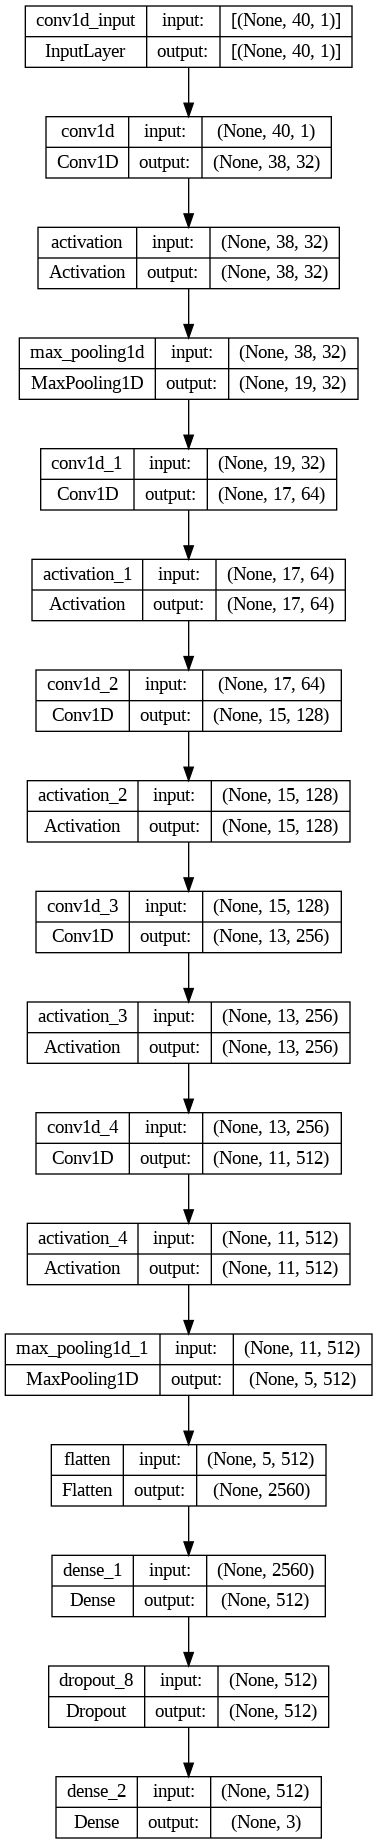

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Confusion Matrix

In [ ]:
import seaborn as sns

In [ ]:
#making the prediction
# Make predictions
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

786/786 [==============================] - 7s 8ms/step


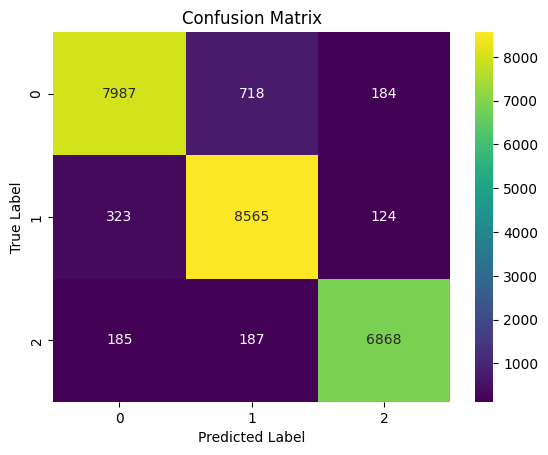

In [ ]:
sns.heatmap(conf_matrix,annot=True, fmt="d", cmap='viridis')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Based on the confusion matrix we can see that our True Positive are high and the false neagtive and flase positives for each class are low.

## Precision-Recall Curve

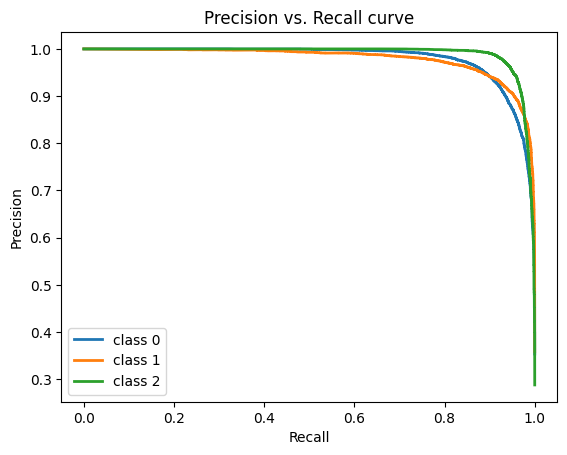

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

# Step 2: Calculate precision and recall for each class
n_classes = predictions.shape[1]
precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], predictions[:, i])

# Step 3: Plotting the curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

## AUC Graph

In [ ]:
from sklearn.metrics import roc_curve, auc

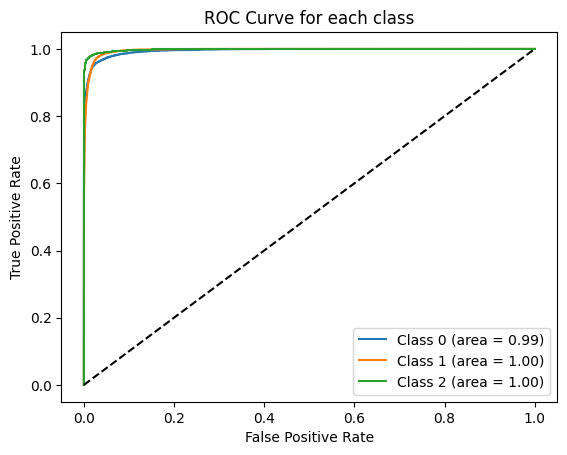

In [ ]:
n_classes = predictions.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Step 3: Plotting the ROC Curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


As for each of the classe we have AUC >0.9, we can that the model is performing really well.